## EXERCISE 1 : Generate 1-D Gaussian Distribution from Uniform Noise
In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, Input
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(1)

Generate training data - Gaussian Distribution

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

Let us define a function that gives you a keras model of general feedforward network based on the parameters.

In [ ]:
#INPUT is of input dim,, goes through n_layers number of hidden layers and output is of output_dim
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',
              optimizer='adam', loss = 'binary_crossentropy'):
    #### YOUR CODE HERE ####


In [ ]:
#INPUT (z) is of random_dim dimension
#OUTPUT should be a keras model - D(G(z)) - Discriminator score for the generator's images generated
#from synthetic data.

def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
    ### YOUR CODE HERE ###

Let us now write the training function for a GAN

In [ ]:
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
  x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
  batch_count = x_train.shape[0]/batch_size

  generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
  discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
  gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

  for e in range(1,epochs+1):

    # Noise is generated from a uniform distribution
    noise = np.random.rand(batch_size,NOISE_DIM)
    true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

    generated_values = generator.predict(noise)
    X = np.concatenate([generated_values,true_batch])

    y_dis = np.zeros(2*batch_size)

    #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
    #the generator may just produce these features only to exploit the discriminator.
    #The optimization may turn too greedy and produces no long term benefit.
    #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
    y_dis[:batch_size] = 0.9

    discriminator.trainable = True
    ###YOUR CODE HERE####
    # One line : Train discriminator using train_on_batch
    discriminator.trainable = False

    # Train generator. Noise is generated from a uniform distribution
    ### YOUR CODE HERE. Couple of lines. Should call gan.train_on_batch()###



  return generator, discriminator


In [ ]:
generator, discriminator = train_gan()

Let us visualize what the generator has learned.

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)


true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

## EXERCISE 2 : Train real GAN - MINST Digit Generation 
Here we try to generate 'fake' digits between 0 and 9 as if they belong to the MINST dataset using a simple Generative Adversarial Network (GAN)

#### Generative Adversarial Networks (GANs)

GANs is a method for training generative models that was proposed in 2014 by Goodfellow et al. There are two neural networks in a GAN. One is called the generator which takes a random noise as input and outputs an image. The other is called the discriminator which is a binary classifier to classify whether an input image is a real image or a fake image generated by the generator. The goal of the generator is to generate images that can fool the discriminator into thinking the images are real.

This iterative process of generator trying to fool the discriminator and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are random noise vectors,  $G(z)$ are the fake images generated by the generator $G$, $D$ is a probability of the input of the discriminator being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

In practice, for the objective of the generator, instead of minimizing the following objection:
$$\underset{G}{\text{minimize}}\; \left[\log \left(1-D(G(z))\right)\right]$$
We use a different objective for the generator: maximizing the probability of the disciminator being fooled.

$$\underset{G}{\text{maximize}}\; \left[\log \left(D(G(z))\right)\right]$$

This helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$



#### Libraries
run this cell before doing anything!

In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Load Data and Explore

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


In [3]:
print(train_ds.data.shape)
print(train_ds.targets.shape)
print(train_ds.classes)
print(train_ds.data[0])
print(train_ds.targets[0])
print(train_ds.data[0].max())
print(train_ds.data[0].min())
print(train_ds.data[0].float().mean())
print(train_ds.data[0].float().std())

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [4]:
# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

In [5]:
# Examine a sample batch from the dataloader
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


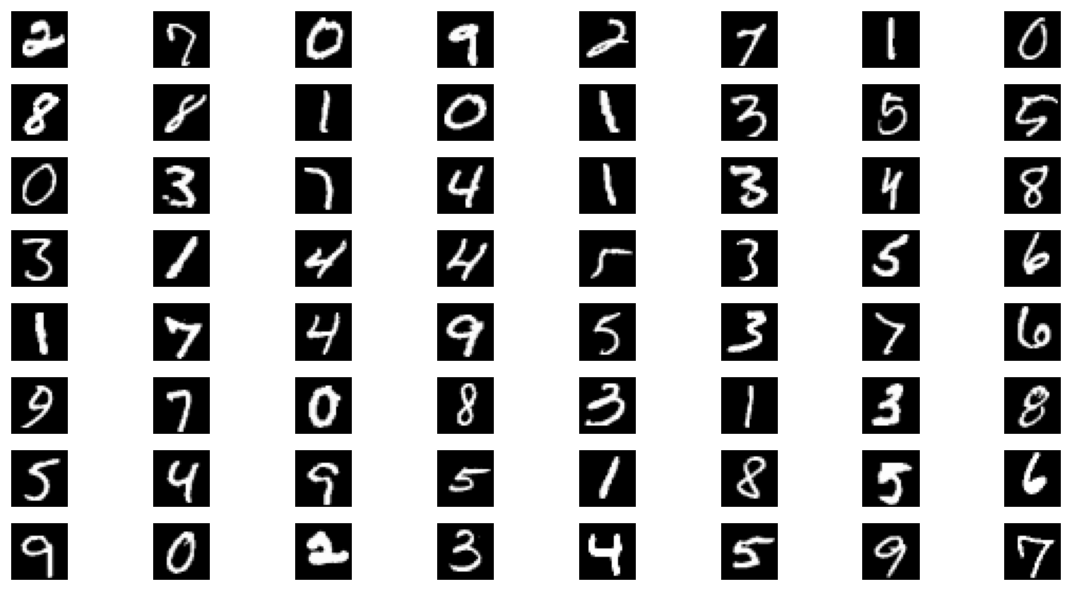

In [6]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid

    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid

    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)

## Define the Network

### Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    """
    The Discriminator class for a Generative Adversarial Network (GAN).

    This model takes an input image (real or generated) and predicts whether it is real or fake.
    It uses a sequence of fully connected layers with LeakyReLU activations and dropout regularization
    to learn complex decision boundaries.

    Constructor (`__init__`):
    - Parameters:
        - `in_features`: Flattened input dimension (e.g., image_size * image_size * channels).
        - `out_features`: Usually 1 (binary real/fake output).
    - Layers:
        - `fc1`: Fully connected layer mapping from `in_features` → 128 hidden units.
        - `fc2`: Linear layer from 128 → 64.
        - `fc3`: Linear layer from 64 → 32.
        - `fc4`: Final layer mapping from 32 → `out_features` (typically 1 for the discriminator output).
        - Each linear layer (except the last) is followed by LeakyReLU activation (negative slope = 0.2)
          and a dropout (0.3) for regularization.

    Forward Pass (`forward`):
    - Steps:
        1. Flatten input images to shape `(batch_size, in_features)`.
        2. Sequentially apply fully connected layers with LeakyReLU and Dropout.
        3. Return the final logit (unnormalized score) from the last layer.

    TO DO:
    - Complete the `__init__` method by defining all the layers listed above.
    - Complete the `forward` method to apply the layers in order and return the output logits.
    """

    def __init__(self, in_features, out_features):
        super().__init__()
        ###############
        ### YOUR CODE HERE ###
        ###############
        # Define all linear layers, LeakyReLU activations, and dropout
        # Example:
        # self.fc1 = nn.Linear(in_features, 128)
        # self.leaky_relu1 = nn.LeakyReLU(0.2)
        # self.dropout = nn.Dropout(0.3)
        # (then continue defining fc2, fc3, fc4, etc.)
        ###############
        ### END OF YOUR CODE ###
        ###############

    def forward(self, x):
        ###############
        ### YOUR CODE HERE ###
        ###############
        # 1. Flatten input: x = x.view(batch_size, -1)
        # 2. Pass through fc1 -> LeakyReLU -> Dropout
        # 3. Pass through fc2 -> LeakyReLU -> Dropout
        # 4. Pass through fc3 -> LeakyReLU -> Dropout
        # 5. Final output through fc4 (no activation here, output is logit)
        # Return the output
        ###############
        ### END OF YOUR CODE ###
        ###############
        return x


### Generator Network

In [ ]:
class Generator(nn.Module):
    """
    The Generator class for a Generative Adversarial Network (GAN).

    This model takes a random noise vector (latent code) and transforms it into a fake image-like output
    that should resemble the real data distribution. It uses several fully connected layers with LeakyReLU
    activations and dropout regularization, followed by a Tanh activation to constrain the output range.

    Constructor (`__init__`):
    - Parameters:
        - `in_features`: Dimensionality of the input noise vector (latent space).
        - `out_features`: Flattened dimensionality of the generated image (e.g., image_size * image_size * channels).
    - Layers:
        - `fc1`: Fully connected layer mapping from latent space → 32.
        - `fc2`: Linear layer from 32 → 64.
        - `fc3`: Linear layer from 64 → 128.
        - `fc4`: Linear layer from 128 → `out_features`.
        - Each layer (except the last) is followed by a LeakyReLU activation and dropout (0.3).
        - The final output layer applies Tanh activation to scale outputs to (-1, 1),
          matching normalized image data.

    Forward Pass (`forward`):
    - Steps:
        1. Pass the latent vector through a series of fully connected layers with LeakyReLU and Dropout.
        2. Apply the final layer to map to the image dimensionality.
        3. Use Tanh activation to normalize output pixel values.
        4. Return the generated image tensor.

    TO DO:
    - Complete the `__init__` method by defining all the layers (fully connected, activations, dropout, and tanh).
    - Complete the `forward` method to apply the layers in order and return the generated fake image.
    """

    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        ###############
        ### YOUR CODE HERE ###
        ###############
        # Define the fully connected layers:
        # Example:
        # self.fc1 = nn.Linear(in_features, 32)
        # self.relu1 = nn.LeakyReLU(0.2)
        # self.dropout = nn.Dropout(0.3)
        # Continue for fc2, fc3, fc4, and include final Tanh activation.
        ###############
        ### END OF YOUR CODE ###
        ###############

    def forward(self, x):
        ###############
        ### YOUR CODE HERE ###
        ###############
        # 1. Pass through fc1 -> LeakyReLU -> Dropout
        # 2. Pass through fc2 -> LeakyReLU -> Dropout
        # 3. Pass through fc3 -> LeakyReLU -> Dropout
        # 4. Pass through fc4 -> Tanh (to get final image output)
        # Return the final generated tensor
        ###############
        ### END OF YOUR CODE ###
        ###############
        return x


## Define Losses
Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`real_labels = torch.ones(real_images.size(0), 1, device=device)`

`fake_labels = torch.zeros(fake_images.size(0), 1, device=device)`

to obtain the loss required gor the generator and discripminator model, you will feed the real images and the fake images to variables 'G' and 'D' respectively 
and calculate loss base on the output of these two modules. note that 'G' is an object of the generator class and 'D' is an object of the discriminator class which you will declare later on in the implementation!

In [ ]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Computes the discriminator loss for *real* samples.

    In GAN training, real samples should be labeled as 1 (real).
    The discriminator is penalized when it assigns a value far from 1 to real data.

    Parameters
    ----------
    predicted_outputs : Tensor
        The discriminator's predicted logits for real samples.
    loss_fn : torch.nn loss function
        Typically `nn.BCEWithLogitsLoss()` or `nn.BCELoss()` for binary classification.
    device : torch.device
        Device on which tensors should be placed (e.g., 'cuda' or 'cpu').

    Returns
    -------
    real_loss : Tensor
        Scalar loss value indicating how well the discriminator identifies real samples.

    TO DO:
    - Create a target tensor of ones (size = batch_size).
    - Compute the loss between predicted logits and the real targets.
    """

    ###############
    ### YOUR CODE HERE ###
    ###############

    ###############
    ### END OF YOUR CODE ###
    ###############

    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Computes the discriminator loss for *fake* (generated) samples.

    In GAN training, fake samples should be labeled as 0 (fake).
    The discriminator is penalized when it assigns a value near 1 to fake data.

    Parameters
    ----------
    predicted_outputs : Tensor
        The discriminator's predicted logits for fake (generated) samples.
    loss_fn : torch.nn loss function
        Typically `nn.BCEWithLogitsLoss()` or `nn.BCELoss()`.
    device : torch.device
        Device on which tensors should be placed (e.g., 'cuda' or 'cpu').

    Returns
    -------
    fake_loss : Tensor
        Scalar loss value indicating how well the discriminator identifies fake samples.

    TO DO:
    - Create a target tensor of zeros (size = batch_size).
    - Compute the loss between predicted logits and the fake targets.
    """

    ###############
    ### YOUR CODE HERE ###
    ###############
    
    ###############
    ### END OF YOUR CODE ###
    ###############

    return fake_loss


## Train the network
Discriminator and Generator will be trained together we need separate optimizer for them

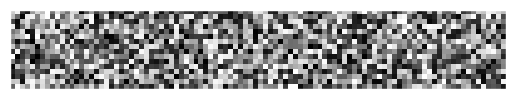

In [10]:
#Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    """
    Trains a Generative Adversarial Network (GAN) using the MNIST dataset.

    This function alternates between training the discriminator and the generator
    to achieve an equilibrium where the discriminator can no longer distinguish
    between real and generated (fake) samples.

    Parameters
    ----------
    d : Discriminator model
        Instance of the Discriminator class.
    g : Generator model
        Instance of the Generator class.
    d_optim : torch.optim.Optimizer
        Optimizer for the discriminator.
    g_optim : torch.optim.Optimizer
        Optimizer for the generator.
    loss_fn : torch.nn loss function
        Typically BCE or BCEWithLogits loss for binary classification.
    dl : DataLoader
        DataLoader for the MNIST dataset.
    n_epochs : int
        Number of epochs to train.
    device : torch.device
        Training device ('cuda' or 'cpu').
    verbose : bool
        If True, prints batch-level progress.

    Returns
    -------
    d_losses : list of float
        Per-epoch discriminator losses.
    g_losses : list of float
        Per-epoch generator losses.

    TO DO:
    - Complete the training logic for discriminator and generator inside the loop.
    - Remember to:
        1. Convert real images from [0, 1] → [-1, 1].
        2. Use `real_loss` for both discriminator (real batch) and generator (fake batch).
        3. Use `fake_loss` for discriminator fake batch.
        4. Accumulate losses and save after each epoch.
        5. Save a fixed set of generated samples after each epoch for later visualization.
    """

    print(f'Training on [{device}]...')

    ###############
    ### YOUR CODE HERE ###
    ###############
    # 1. Initialize latent vector size and fixed_z for consistent sample visualization.
    # z_size = 100
    # fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    # fixed_z = torch.from_numpy(fixed_z).float().to(device)

    # 2. Move models to device and initialize empty loss containers.
    # d.to(device)
    # g.to(device)
    # d_losses, g_losses, fixed_samples = [], [], []

    # 3. For each epoch:
    #   a. Set models to train mode.
    #   b. Iterate over batches of real images.
    #   c. Train discriminator:
    #       - Compute d_real_loss using real_loss()
    #       - Generate fake images with G (detach to avoid generator gradient)
    #       - Compute d_fake_loss using fake_loss()
    #       - Combine and backpropagate total discriminator loss.
    #   d. Train generator:
    #       - Generate fake images again (without detach).
    #       - Compute g_loss using real_loss() (target = 1).
    #       - Backpropagate generator loss.
    #   e. Track batch losses and print progress every few iterations.
    #
    # 4. Compute average epoch losses and append to loss lists.
    # 5. Generate and store fake samples from fixed_z for each epoch.
    # 6. At the end, save the generated samples to a .pkl file.
    ###############
    ### END OF YOUR CODE ###
    ###############

    return d_losses, g_losses


In [ ]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim,
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

In [ ]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [21]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

In [ ]:
show_generated_images(epoch=1, n_cols=8)

In [ ]:
show_generated_images(epoch=10, n_cols=8)

In [ ]:
show_generated_images(epoch=50, n_cols=8)

In [ ]:
show_generated_images(epoch=100, n_cols=8)

## Test the network
The trained generator can be used to generate a fake random digit that'd look like as if it came from MNIST dataset.
Discriminator can be discarded now.

In [ ]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))